In [1]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import math
import copy
import io
import time
import matplotlib.pyplot as plt
import seaborn as sns


import torch
import torchvision
import torch
import torch.nn as nn
from torch import cuda
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torch.mps as mps


if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'

print(f"Using device: {device}")

import sys
sys.path.append('models_scratch/')
from models_scratch import *

torch.manual_seed(42)
#torch.use_deterministic_algorithms(True)

Using device: cuda


In [2]:
infile = open('data/EuroSATData_bin.pk','rb')
SavedData = pickle.load(infile)
infile.close()

In [3]:
X_train = SavedData["X_train"]
S_train = SavedData["S_train"]
y_train = SavedData["Y_train"]
X_test = SavedData["X_test"]
S_test = SavedData["S_test"]
y_test = SavedData["Y_test"]

print(100*((S_train == 0).sum().item())/(S_train == 1).sum().item())  # 3% images bluish

3.199174406604747


In [4]:
def build_model(network, num_classes, input_channels, input_height, input_width, device, batch_norm=False):
    
    if batch_norm:
        norm_layer = nn.BatchNorm2d
    else:
        norm_layer = None

    if network == "vgg11":
        net = VGG("VGG11", num_classes=num_classes, batch_norm=False)
    elif network == "vgg16":
        net = VGG("VGG16", num_classes=num_classes, batch_norm=False)
    elif network == "resnet18":
        net = resnet18(norm_layer=norm_layer, num_classes=num_classes)
    elif network == "resnet34":
        net = resnet34(norm_layer=norm_layer, num_classes=num_classes)
    elif network == "resnet50":
        net = resnet50(norm_layer=norm_layer, num_classes=num_classes)
    elif network == "densenet121":
        net = densenet121(norm_layer=norm_layer, num_classes=num_classes)
        net.head = nn.Linear(net.head.in_features, num_classes)
    elif network == "lenet":
        net = LeNet5(num_classes=num_classes, input_channels=input_channels, input_height=input_height, input_width=input_width)
    else:
        raise ValueError("Invalid network name.")

    net = net.to(device)
    
    num_params = sum(p.numel() for p in net.parameters())
    print(f"Total number of parameters in {network}: {num_params:,}")
    
    class ModelWithPredict(nn.Module):
        def __init__(self, base_model):
            super().__init__()
            self.base_model = base_model

        def forward(self, x):
            output = self.base_model(x)
            return torch.sigmoid(output)

        def predict(self, X):
            prediction_probabilities = self(X)
            return 1. * (prediction_probabilities > 0.5)

        def predict_probabilities(self, X):
            return self(X)

    net = ModelWithPredict(net)
    
    return net

input_channels = X_train.shape[1]
input_height = X_train.shape[2]
input_width = X_train.shape[3]
net = build_model("resnet18", 1, input_channels, input_height, input_width, device)

Total number of parameters in resnet18: 11,159,745


In [5]:
class CustomDataset(Dataset):
    def __init__(self, X, S, y):
        self.X = X
        self.S = S
        self.y = y
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.S[idx], self.y[idx]

In [6]:
def train_model(network, X_train, S_train, y_train, X_test, S_test, y_test, 
                epochs=10, batch_size=64, learning_rate=0.05, device='cpu', batch_norm=False, kappa=90, tau=90):
    
    trainset = TensorDataset(X_train, S_train, y_train)
    testset  = TensorDataset(X_test, S_test, y_test)
    trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
    testloader  = DataLoader(testset, batch_size=100, shuffle=False)
    
    input_channels, input_height, input_width = X_train.shape[1], X_train.shape[2], X_train.shape[3]
    model = build_model(network, num_classes=1, input_channels=input_channels, 
                        input_height=input_height, input_width=input_width, device=device, batch_norm=batch_norm)
    
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0)
    criterion = nn.MSELoss(reduction='sum')
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
    
    # Initialisation des listes pour stocker les métriques par époque
    train_loss_s0, train_loss_s1, train_loss_all = [], [], []
    test_loss_s0, test_loss_s1, test_loss_all = [], [], []
    train_acc_s0, train_acc_s1, train_acc_all = [], [], []
    test_acc_s0, test_acc_s1, test_acc_all = [], [], []
    times, cumulative_time = [], 0
    
    early_stopping_epoch = None
    final_epoch = None

    # Initialisation des "meilleurs" scores (pour suivre l'évolution)
    best_train_loss_s0 = float('inf')
    best_train_loss_s1 = float('inf')
    best_train_loss    = float('inf')
    best_test_loss_s0  = float('inf')
    best_test_loss_s1  = float('inf')
    best_test_loss     = float('inf')
    best_train_acc_s0  = 0
    best_train_acc_s1  = 0
    best_train_acc     = 0
    best_test_acc_s0   = 0
    best_test_acc_s1   = 0
    best_test_acc      = 0
    
    nb_epochs = 0

    for epoch in range(epochs):
        start_time = time.time()
        model.train()
        
        total_loss, total_samples = 0.0, 0
        loss_s0_sum, count_s0 = 0.0, 0
        loss_s1_sum, count_s1 = 0.0, 0
        correct_total, correct_s0, correct_s1 = 0, 0, 0
        
        for X_batch, S_batch, y_batch in trainloader:
            X_batch, S_batch, y_batch = X_batch.to(device), S_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            y_batch = y_batch.float().view(-1, 1)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            
            bsize = y_batch.size(0)
            total_loss += loss.item() #* bsize
            total_samples += bsize
            
            preds = (outputs > 0.5).float()
            correct_total += preds.eq(y_batch).sum().item()
            
            mask_s0 = (S_batch == 0)
            if mask_s0.any():
                n_s0 = mask_s0.sum().item()
                loss_s0 = criterion(outputs[mask_s0], y_batch[mask_s0]).item()
                loss_s0_sum += loss_s0 #* n_s0
                count_s0 += n_s0
                correct_s0 += preds[mask_s0].eq(y_batch[mask_s0]).sum().item()
                
            mask_s1 = (S_batch == 1)
            if mask_s1.any():
                n_s1 = mask_s1.sum().item()
                loss_s1 = criterion(outputs[mask_s1], y_batch[mask_s1]).item()
                loss_s1_sum += loss_s1 #* n_s1
                count_s1 += n_s1
                correct_s1 += preds[mask_s1].eq(y_batch[mask_s1]).sum().item()
        
        avg_loss    = total_loss / total_samples
        avg_loss_s0 = loss_s0_sum / count_s0 #total_samples 
        avg_loss_s1 = loss_s1_sum / count_s1 #total_samples
        
        acc_total = (correct_total / total_samples) * 100
        acc_s0    = (correct_s0 / count_s0) * 100
        acc_s1    = (correct_s1 / count_s1) * 100 
        
        best_train_loss_s0 = min(best_train_loss_s0, avg_loss_s0) #avg_loss_s0
        best_train_loss_s1 = min(best_train_loss_s1, avg_loss_s1) #avg_loss_s1
        best_train_loss    = min(best_train_loss, avg_loss) #avg_loss
        best_train_acc_s0  = max(best_train_acc_s0, acc_s0) #acc_s0
        best_train_acc_s1  = max(best_train_acc_s1, acc_s1) #acc_s1
        best_train_acc     = max(best_train_acc, acc_total) #acc_total
        
        train_loss_s0.append(best_train_loss_s0)
        train_loss_s1.append(best_train_loss_s1)
        train_loss_all.append(best_train_loss)
        train_acc_s0.append(best_train_acc_s0)
        train_acc_s1.append(best_train_acc_s1)
        train_acc_all.append(best_train_acc)
        
        if early_stopping_epoch is None and best_train_acc > tau:
            early_stopping_epoch = epoch + 1
        
        model.eval()
        test_loss_sum, total_test = 0.0, 0
        loss_s0_test_sum, count_s0_test = 0.0, 0
        loss_s1_test_sum, count_s1_test = 0.0, 0
        correct_test_total, correct_s0_test, correct_s1_test = 0, 0, 0
        
        with torch.no_grad():
            for X_batch, S_batch, y_batch in testloader:
                X_batch, S_batch, y_batch = X_batch.to(device), S_batch.to(device), y_batch.to(device)
                y_batch = y_batch.float().view(-1, 1)
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                bsize = y_batch.size(0)
                test_loss_sum += loss.item() #* bsize
                total_test += bsize
                
                preds = (outputs > 0.5).float()
                correct_test_total += preds.eq(y_batch).sum().item()
                
                mask_s0 = (S_batch == 0)
                if mask_s0.any():
                    n_s0 = mask_s0.sum().item()
                    loss_s0 = criterion(outputs[mask_s0], y_batch[mask_s0]).item()
                    loss_s0_test_sum += loss_s0 #* n_s0
                    count_s0_test += n_s0
                    correct_s0_test += preds[mask_s0].eq(y_batch[mask_s0]).sum().item()
                
                mask_s1 = (S_batch == 1)
                if mask_s1.any():
                    n_s1 = mask_s1.sum().item()
                    loss_s1 = criterion(outputs[mask_s1], y_batch[mask_s1]).item()
                    loss_s1_test_sum += loss_s1 #* n_s1
                    count_s1_test += n_s1
                    correct_s1_test += preds[mask_s1].eq(y_batch[mask_s1]).sum().item()
        
        avg_loss_test    = test_loss_sum / total_test
        avg_loss_s0_test = loss_s0_test_sum / count_s0_test #total_test
        avg_loss_s1_test = loss_s1_test_sum / count_s1_test #total_test
        
        acc_test         = (correct_test_total / total_test) * 100
        acc_s0_test      = (correct_s0_test / count_s0_test) * 100 if count_s0_test > 0 else 0
        acc_s1_test      = (correct_s1_test / count_s1_test) * 100 if count_s1_test > 0 else 0
        
        best_test_loss_s0 = min(best_test_loss_s0, avg_loss_s0_test) #avg_loss_s0_test 
        best_test_loss_s1 = min(best_test_loss_s1, avg_loss_s1_test) #avg_loss_s1_test
        best_test_loss    = min(best_test_loss, avg_loss_test) #avg_loss_test
        best_test_acc_s0  = max(best_test_acc_s0, acc_s0_test) #acc_s0_test
        best_test_acc_s1  = max(best_test_acc_s1, acc_s1_test) #acc_s1_test
        best_test_acc     = max(best_test_acc, acc_test) #acc_test
        
        test_loss_s0.append(best_test_loss_s0)
        test_loss_s1.append(best_test_loss_s1)
        test_loss_all.append(best_test_loss)
        test_acc_s0.append(best_test_acc_s0)
        test_acc_s1.append(best_test_acc_s1)
        test_acc_all.append(best_test_acc)
        
        cumulative_time += time.time() - start_time
        times.append(cumulative_time)
        
        if (epoch + 1) % 50 == 0 or epoch == 0:
            print(f"Epoch [{epoch+1}/{epochs}] | Time: {cumulative_time:.2f}s")
            print(f"  Train -> Loss: S0={avg_loss_s0:.4f}, S1={avg_loss_s1:.4f}, Global={avg_loss:.4f} | "
                  f"Acc: S0={acc_s0:.2f}%, S1={acc_s1:.2f}%, Global={acc_total:.2f}%")
            print(f"  Test  -> Loss: S0={avg_loss_s0_test:.4f}, S1={avg_loss_s1_test:.4f}, Global={avg_loss_test:.4f} | "
                  f"Acc: S0={acc_s0_test:.2f}%, S1={acc_s1_test:.2f}%, Global={acc_test:.2f}%")
        #scheduler.step()
        nb_epochs += 1
        
        if best_train_acc_s0 > kappa:
            final_epoch = epoch + 1
            break
            
    if final_epoch is None:
        final_epoch = epochs

    debiasing_duration = (final_epoch - early_stopping_epoch) if early_stopping_epoch is not None else None

    print(f"\nTraining finished in {final_epoch} epochs.")
    if early_stopping_epoch:
        print(f"→ Early stopping threshold (Acc > τ={tau}%) reached at epoch {early_stopping_epoch}.")
    print(f"→ Fairness threshold (Acc_S=0 > κ={kappa}%) reached at epoch {final_epoch}.")
    if early_stopping_epoch:
        print(f"→ Debiasing duration: {debiasing_duration} epochs.")

    return {
         "times": np.array(times),
         "epoch": np.arange(1, nb_epochs + 1),
         "train_loss_s0": np.array(train_loss_s0),
         "train_loss_s1": np.array(train_loss_s1),
         "train_loss_all": np.array(train_loss_all),
         "test_loss_s0": np.array(test_loss_s0),
         "test_loss_s1": np.array(test_loss_s1),
         "test_loss_all": np.array(test_loss_all),
         "train_acc_s0": np.array(train_acc_s0),
         "train_acc_s1": np.array(train_acc_s1),
         "train_acc_all": np.array(train_acc_all),
         "test_acc_s0": np.array(test_acc_s0),
         "test_acc_s1": np.array(test_acc_s1),
         "test_acc_all": np.array(test_acc_all)
    }

def run_multiple_experiments(network, X_train, S_train, y_train, X_test, S_test, y_test,
                             epochs=10, batch_size=64, learning_rate=0.05, device='cpu', num_runs=5, batch_norm=False):
    records = []
    
    for run in range(num_runs):
        print(f"\n--- Run {run+1}/{num_runs} ---")
        result = train_model(network, X_train, S_train, y_train, X_test, S_test, y_test,
                             epochs=epochs, batch_size=batch_size, learning_rate=learning_rate, device=device, batch_norm=batch_norm)
        for i, epoch in enumerate(result["epoch"]):
            record = {
                "num_run": run+1,
                "epoch": result["epoch"][i],
                "time": result["times"][i],
                "train_loss_all": result["train_loss_all"][i],
                "train_loss_s0": result["train_loss_s0"][i],
                "train_loss_s1": result["train_loss_s1"][i],
                "test_loss_all": result["test_loss_all"][i],
                "test_loss_s0": result["test_loss_s0"][i],
                "test_loss_s1": result["test_loss_s1"][i],
                "train_acc_all": result["train_acc_all"][i],
                "train_acc_s0": result["train_acc_s0"][i],
                "train_acc_s1": result["train_acc_s1"][i],
                "test_acc_all": result["test_acc_all"][i],
                "test_acc_s0": result["test_acc_s0"][i],
                "test_acc_s1": result["test_acc_s1"][i],
            }
            records.append(record)
    
    df = pd.DataFrame(records)
    df["epoch"] = df["epoch"].astype(int)  # s'assurer que les epochs sont en entier
    
    return df

In [7]:
df_results = run_multiple_experiments("resnet18", X_train, S_train, y_train, X_test, S_test, y_test,
                             epochs=1000, batch_size=512, learning_rate=1e-4, device='cuda', num_runs=2, batch_norm=False)


--- Run 1/2 ---
Total number of parameters in resnet18: 11,159,745
Epoch [1/1000] | Time: 1.29s
  Train -> Loss: S0=0.2698, S1=0.2524, Global=0.2529 | Acc: S0=37.10%, S1=49.90%, Global=49.50%
  Test  -> Loss: S0=0.2548, S1=0.2467, Global=0.2470 | Acc: S0=30.95%, S1=50.84%, Global=50.00%
Epoch [50/1000] | Time: 23.40s
  Train -> Loss: S0=0.2384, S1=0.1877, Global=0.1892 | Acc: S0=62.90%, S1=71.05%, Global=70.80%
  Test  -> Loss: S0=0.2249, S1=0.1768, Global=0.1788 | Acc: S0=69.05%, S1=76.10%, Global=75.80%
Epoch [100/1000] | Time: 45.72s
  Train -> Loss: S0=0.2457, S1=0.1648, Global=0.1673 | Acc: S0=66.94%, S1=76.19%, Global=75.90%
  Test  -> Loss: S0=0.2508, S1=0.1553, Global=0.1593 | Acc: S0=66.67%, S1=78.39%, Global=77.90%
Epoch [150/1000] | Time: 68.36s
  Train -> Loss: S0=0.2105, S1=0.1206, Global=0.1234 | Acc: S0=70.97%, S1=83.93%, Global=83.53%
  Test  -> Loss: S0=0.2687, S1=0.1377, Global=0.1432 | Acc: S0=69.05%, S1=81.00%, Global=80.50%
Epoch [200/1000] | Time: 90.90s
  Train 

In [8]:
def plot_xp(df, network, kappa=90):
    import matplotlib.pyplot as plt
    import seaborn as sns
    import pandas as pd
    from matplotlib.ticker import MaxNLocator
    from matplotlib.lines import Line2D

    df_loss_train = df.melt(id_vars=["num_run", "epoch", "time"], 
                            value_vars=["train_loss_all", "train_loss_s0", "train_loss_s1"],
                            var_name="group", value_name="train_loss")
    df_acc_train = df.melt(id_vars=["num_run", "epoch", "time"], 
                           value_vars=["train_acc_all", "train_acc_s0", "train_acc_s1"],
                           var_name="group", value_name="train_acc")
    df_acc_test = df.melt(id_vars=["num_run", "epoch", "time"], 
                          value_vars=["test_acc_all", "test_acc_s0", "test_acc_s1"],
                          var_name="group", value_name="test_acc")

    mapping = {
        "train_loss_all": "Global", "train_loss_s0": "A=0", "train_loss_s1": "A=1",
        "train_acc_all": "Global", "train_acc_s0": "A=0", "train_acc_s1": "A=1",
        "test_acc_all": "Global", "test_acc_s0": "A=0", "test_acc_s1": "A=1"
    }

    for df_, name in [(df_loss_train, "group"), (df_acc_train, "group"), (df_acc_test, "group")]:
        df_[name] = df_[name].map(mapping)

    palette = {"A=0": "blue", "A=1": "orange", "Global": "green"}

    fig, axs = plt.subplots(1, 3, figsize=(14, 4), sharex=True)

    sns.lineplot(ax=axs[0], data=df_loss_train, x="epoch", y="train_loss", hue="group",
                 estimator='mean', errorbar='sd', palette=palette)
    axs[0].set_yscale("log")
    axs[0].set_xlabel("Epoch", fontsize=14)
    axs[0].set_ylabel("Train loss", fontsize=14)
    axs[0].grid(True)
    axs[0].get_legend().remove()

    sns.lineplot(ax=axs[1], data=df_acc_train, x="epoch", y="train_acc", hue="group",
                 estimator='mean', errorbar='sd', palette=palette)
    axs[1].set_xlabel("Epoch", fontsize=14)
    axs[1].set_ylabel("Train accuracy (%)", fontsize=14)
    axs[1].axhline(kappa, color='red', linestyle='--', linewidth=1)
    #axs[1].annotate(rf"$\kappa$ = {int(kappa)}",
                   # xy=(-0.1, kappa), xycoords=('axes fraction', 'data'),
                    #fontsize=10, color='red', va='center', ha='right')
    axs[1].grid(True)
    axs[1].get_legend().remove()

    sns.lineplot(ax=axs[2], data=df_acc_test, x="epoch", y="test_acc", hue="group",
                 estimator='mean', errorbar='sd', palette=palette)
    axs[2].set_xlabel("Epoch", fontsize=14)
    axs[2].set_ylabel("Test accuracy (%)", fontsize=14)
    axs[2].grid(True)
    axs[2].get_legend().remove()

    # Courbes des groupes
    handles = [Line2D([0], [0], color=color, lw=2, label=label) for label, color in palette.items()]
    # Ligne rouge seuil kappa
    kappa_line = Line2D([0], [0], color='red', lw=1, linestyle='--', label=r"$\kappa$ threshold")
    handles.append(kappa_line)

    fig.legend(handles, [h.get_label() for h in handles], loc='lower center',
               ncol=4, bbox_to_anchor=(0.5, -0.15), fontsize=14)

    for ax in axs:
        ax.xaxis.set_major_locator(MaxNLocator(integer=True))

    plt.tight_layout()
    plt.savefig(f"results/EuroSAT/eurosat_{network}_metrics_with_kappa.pdf", bbox_inches="tight")
    plt.show()

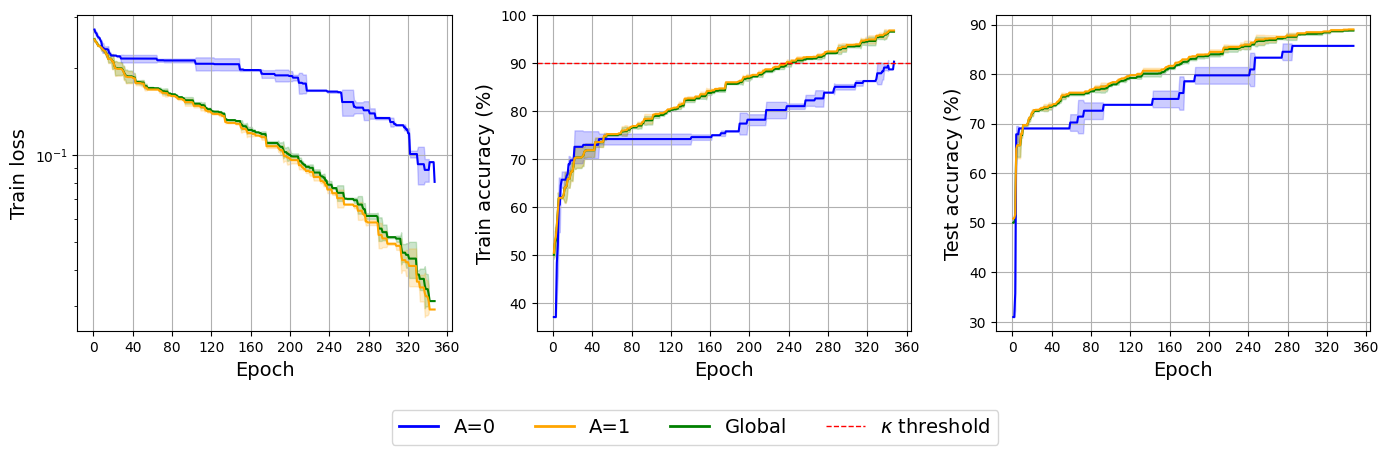

In [9]:
plot_xp(df_results,'resnet18')